## Détermination de groupes de codes postaux

#### Idée
 les codes postaux ont été anonymisés, ils constituent donc une boîte noire que l'on ne peut pas utiliser telle quelle. <br/>Par contre, on peut supposer que certains types de vêtements associés à un type de climat (shorts, manteaux) n'ont pas les mêmes figures de ventes selon la zone géographique et éventuellement l'hémisphère.<br/>-> Nous allons donc tenter de déterminer des groupes de codes postaux.
#### Features à contruire 
- Différentiel entre le minimum et le maximum de ventes pour chaque type de produit
- Pic de vente pour chaque type de produit.

In [52]:
import pandas as pd
import numpy as np

### Création des features

In [7]:
transactions = pd.read_pickle('pickles/transactions.pkl')

In [3]:
transactions.drop(['t_dat', 'price', 'sales_channel_id', 'day_of_week', 'day_of_year'], 1, inplace = True)

/tmp/ipykernel_6514/1705565447.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  transactions.drop(['t_dat', 'price', 'sales_channel_id', 'day_of_week', 'day_of_year'], 1, inplace = True)


In [4]:
sales_by_week = transactions.groupby(['week_number', 'customer_id', 'article_id'], as_index = False).agg(
    sales = ('article_id', 'count')
)

In [5]:
postal_codes = pd.read_pickle('pickles/customers_clean.pkl')
postal_codes = postal_codes[['customer_id', 'postal_code']]

In [6]:
sales_by_week = sales_by_week.merge(postal_codes, on = 'customer_id', how = 'left')

In [7]:
sales_by_postal_code = sales_by_week.groupby(['article_id', 'week_number', 'postal_code'], as_index = False).agg(
    sales = ('sales', 'sum')
)

In [8]:
sales_by_postal_code.to_pickle('pickles/sales_by_postal_code.pkl')

In [9]:
# Ajout du type de produit
articles = pd.read_pickle('pickles/articles_clean.pkl')
sales_by_postal_code = pd.read_pickle('pickles/sales_by_postal_code.pkl')

In [10]:
articles = articles[['article_id', 'product_type_name']]
sales_by_postal_code = sales_by_postal_code.merge(articles, how = 'left', on = 'article_id')

In [11]:
# Groupage et préparation des features
sales_by_product_type = sales_by_postal_code.groupby(['week_number', 'postal_code', 'product_type_name'], as_index = False).agg(
    sales = ('sales', 'sum')
)

In [12]:
sales_by_product_type.to_pickle('pickles/sales_by_product_type.pkl')

In [14]:
# Récupérer le minimum et le maximum de vente pour chaque catégorie et code postal.
sales_category_boundaries = sales_by_product_type.groupby(['postal_code', 'product_type_name'], as_index = False).agg(
    sales_min = ('sales', 'min'),
    sales_max = ('sales', 'max'),
    max_index = ('sales', 'idxmax')
)

In [ ]:
sales_category_boundaries.to_pickle('pickles/sales_category_boundaries.pkl')


In [3]:
sales_by_product_type = pd.read_pickle('pickles/sales_by_product_type.pkl')
sales_category_boundaries = pd.read_pickle('pickles/sales_category_boundaries.pkl')

In [ ]:
week_number_max = sales_by_product_type.loc[sales_category_boundaries['max_index']]['week_number']


In [ ]:
sales_category_boundaries['week_number_max'] = week_number_max.reset_index()['week_number']

In [ ]:
sales_category_boundaries.drop('max_index', 1, inplace = True)

/tmp/ipykernel_24448/1425819461.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  sales_category_boundaries.drop('max_index', 1, inplace = True)


In [ ]:
sales_category_boundaries.to_pickle('pickles/sales_category_boundaries.pkl')

In [15]:
# Mapping des types de produits dans les codes postaux
sales_category_boundaries = pd.read_pickle('pickles/sales_category_boundaries.pkl')
postal_codes = pd.DataFrame()

postal_codes['postal_code'] = sales_category_boundaries['postal_code'].unique()
product_types = sales_category_boundaries['product_type_name'].sort_values().unique()

In [17]:
#Don't use every product types, only those who has something to do with local weather.
product_types_kept = ['Bikini top', 'Blanket', 'Coat', 'Gloves', 'Hoodie',
       'Jacket','Scarf', 'Shorts', 'Sunglasses', 'Sweater', 'Swimwear bottom',
       'Swimwear set', 'Swimwear top', 'Umbrella']

In [19]:


for product_type in product_types_kept:
    prefix = f"{product_type}".lower()
    
    product_type_feats = sales_category_boundaries[sales_category_boundaries['product_type_name'] == product_type]
    product_type_feats = product_type_feats.rename({
        'sales_min': f'{prefix}_min',
        'sales_max': f'{prefix}_max',
        'week_number_max': f'{prefix}_peak',
    }, axis = 1).drop(columns = 'product_type_name', axis = 1)
    
    postal_codes = postal_codes.merge(product_type_feats, on = 'postal_code', how = 'left')
    

In [22]:
postal_codes.dropna(subset = ['postal_code'], inplace = True)
postal_codes.to_pickle('pickles/postal_codes_features')
postal_codes

,postal_code,bikini top_min_x,bikini top_max_x,bikini top_peak_x,blanket_min_x,blanket_max_x,blanket_peak_x,coat_min_x,coat_max_x,coat_peak_x,...,swimwear bottom_peak_y,swimwear set_min_y,swimwear set_max_y,swimwear set_peak_y,swimwear top_min_y,swimwear top_max_y,swimwear top_peak_y,umbrella_min_y,umbrella_max_y,umbrella_peak_y
0,0000198d2c593b7d3df5a35282b74cf3a487b066286b2b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00005652fb5323679a5d608ce8c94fbb57bc15d3d8c01a...,1.0,1.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,...,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000eda740da878fb9df474806be9597f043eb5f748091...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0001617618d0facf2ae73cdba7b8caefb3c05e6987a98a...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00016f13cb796865b053cda4d470b4a3146553eaa36241...,1.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352331,ffffcc2ddf5fbe05ea3e2bdb5f920237c5167862fa906a...,1.0,3.0,17.0,NaN,NaN,NaN,1.0,1.0,81.0,...,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
352332,ffffd89fe6a23128efcee162ad22b229e0c7e3d9bba5a3...,1.0,5.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
352333,ffffdad63acd760f392e724af1e8fe05984ebef3749ede...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
352334,ffffdb8046b028cc705ae0b3bc0267ac7f2a44cd1e4b0b...,1.0,5.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalization et réduction de dimension
Voir le code de `preparing_postal_code_features.py`

### Lancement du modèle

In [2]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from utils.map12_from_series import map12_from_series

postal_codes = pd.read_pickle('pickles/postal_codes_features')
feats = postal_codes.drop(columns = 'postal_code', axis = 1).fillna(0).astype(int)

pca = PCA(n_components=0.95)
scaler = MinMaxScaler()     

pipeline = Pipeline(steps = [
    ('scaler', scaler),
    ('pca', pca),                       
])

In [3]:
# Chargement des transactions pour créer un jeu de données de validation
transactions = pd.read_pickle('pickles/transactions.pkl')
customers = pd.read_pickle('pickles/customers.pkl')

In [4]:
last_week_sales = transactions[transactions['week_number'] == 0]
last_week_sales = last_week_sales.merge(customers[['customer_id', 'postal_code']], on = 'customer_id', how = 'left')

validation_data = last_week_sales.groupby(['customer_id', 'postal_code'], as_index = False).agg(
    purchased_articles = ('article_id', lambda x: list(x))
)

In [5]:

# Groupage par code postal
last_week_sales = last_week_sales.groupby(['postal_code', 'article_id'], as_index = False).agg(
    sales = ('article_id', 'count')
)

In [6]:
validation_data['postal_code'].isna().sum()

0

In [7]:
# Calculer le score MAP@12 de la liste des articles les plus populaires, comme point de comparaison
top_sales_list = last_week_sales.groupby('article_id', as_index = False).agg(
    sales = ('article_id', 'count')
).nlargest(12, 'sales')['article_id'].to_list()

top_sales = validation_data[['purchased_articles']]
top_sales['prediction'] = [top_sales_list] * len(top_sales)

top_sales_score = map12_from_series(top_sales['purchased_articles'], top_sales['prediction']).sum() / len(top_sales)
print("Score des articles les plus populaires: ", top_sales_score)

/tmp/ipykernel_21173/3372434727.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_sales['prediction'] = [top_sales_list] * len(top_sales)


Score des articles les plus populaires:  0.010221290725402028


### Recherche de la meilleure clusterisation
#### 1. Sans features polynomiales

In [ ]:
X = pipeline.fit_transform(feats)

In [ ]:
# Recherche du nombre de clusters qui donnera le meilleur score MAP@12
score_curve = [top_sales_score] 
best_score = 0

for k in range(2, 10):
    
    print(f"\r Entraînement pour {k} clusters                    ", end="")
    model = KMeans(n_clusters=k).fit(X)
    clusters = model.predict(X)
    
    # Process a top sales list for each groups.
    postal_codes_groups = postal_codes[['postal_code']]
    postal_codes_groups.loc[:, 'group'] = clusters
    
    top_sales_by_group = last_week_sales.merge(postal_codes_groups, on ='postal_code', how='left').groupby(
        ['group', 'article_id'],
        as_index = False
    ).agg(
        sales = ('sales', 'sum')
    )
    
    print(f"\r Mise en forme des données                   ", end="")
    
    # Assign the lists to each postal code
    top_sales_lists = {}
    for group in range(0, k + 1):
        top_sales_lists[group] = top_sales_by_group.loc[top_sales_by_group['group'] == group].nlargest(12, columns = ['sales'])['article_id'].to_list()
    
    postal_codes_groups.loc[:, 'prediction'] = postal_codes_groups.loc[:, 'group'].apply(lambda x: top_sales_lists[x])
    
    # Put the prediction aside of the real lists.
    validation_data_with_prediction = validation_data.merge(postal_codes_groups, on = 'postal_code', how='left')
    
    print(f"\r Calcul du score pour {k} clusters                 ", end="")
    score = map12_from_series(validation_data_with_prediction['purchased_articles'], validation_data_with_prediction['prediction']).sum() / len(validation_data_with_prediction)
    
    print(f"Score pour {k} clusters: {score}")
    
    if score > best_score:
        best_model = model
        best_clusters = clusters
        
    score_curve.append(score)

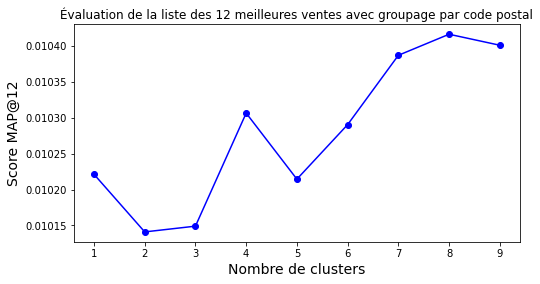

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), score_curve, "bo-")
plt.xlabel("Nombre de clusters", fontsize=14)
plt.ylabel("Score MAP@12", fontsize=14)
plt.title('Évaluation de la liste des 12 meilleures ventes avec groupage par code postal')
plt.show()

#### 2. Avec features polynomiales

In [4]:
# Ajout des features polynomiales

polynomial_features = PolynomialFeatures(degree=2)
X = pca.fit_transform(feats)
X = polynomial_features.fit_transform(X)
X = pca.fit_transform(X)
X = scaler.fit_transform(X)

In [5]:
# Partons sur 8 groupes.
 
kmeans = KMeans(n_clusters=8)
clusters = kmeans.fit_predict(X)

In [14]:
### Calcul du score

# Process a top sales list for each groups.
postal_codes_groups = postal_codes[['postal_code']]
postal_codes_groups.loc[:, 'group'] = clusters

top_sales_by_group = last_week_sales.merge(postal_codes_groups, on ='postal_code', how='left').groupby(
    ['group', 'article_id'],
    as_index = False
).agg(
    sales = ('sales', 'sum')
)

# Assign the lists to each postal code
top_sales_lists = {}
for group in range(0, 9):
    top_sales_lists[group] = top_sales_by_group.loc[top_sales_by_group['group'] == group].nlargest(12, columns = ['sales'])['article_id'].to_list()

postal_codes_groups.loc[:, 'prediction'] = postal_codes_groups.loc[:, 'group'].apply(lambda x: top_sales_lists[x])

# Put the prediction aside of the real lists.
validation_data_with_prediction = validation_data.merge(postal_codes_groups, on = 'postal_code', how='left')

score = map12_from_series(validation_data_with_prediction['purchased_articles'], validation_data_with_prediction['prediction']).sum() / len(validation_data_with_prediction)

print("Score pour 8 clusters et features polynomiales:", score)

Score pour 8 clusters et features polynomiales: 0.010348885434011204


In [7]:
postal_codes_groups.to_pickle("pickles/postal_code_groups.pkl")

#### Conclusion
Le groupage par code postal semble amener un petit plus, mais très faible.